#### Exploration of Corbin Burnes' 2021 NL Cy Young Season

+ This is a simple exercise in data exploration, greatly benefitted by the PyBaseball package. Any use of PyBaseball code that has been edited will be commented as such, and edits made will be listed. 

In [1]:
from pybaseball import statcast_pitcher, playerid_lookup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Simple function to create a one-step process to retrieve pitch-level data 
def get_data(last_name, first_name, start_date, end_date):
    id_df = playerid_lookup(last_name, first_name)
    id = id_df['key_mlbam'].iloc[0]
    data = statcast_pitcher(start_date, end_date, player_id = id)
    return data

In [16]:
#Using function from above to get data and take a quick look
data = get_data('burnes', 'corbin', '2021-03-27', '2021-10-30')
data.head()

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,FC,2021-10-08,97.0,-1.01,5.95,"Burnes, Corbin",645277,669203,strikeout,called_strike,...,0,0,0,Infield shift,Standard,194.0,0.016,-0.134,NaN,NaN
1,CU,2021-10-08,83.9,-0.64,6.14,"Burnes, Corbin",645277,669203,NaN,foul,...,0,0,0,Infield shift,Standard,42.0,0.000,0.000,NaN,NaN
2,FC,2021-10-08,96.4,-0.91,5.98,"Burnes, Corbin",645277,669203,NaN,ball,...,0,0,0,Infield shift,Standard,196.0,0.000,0.043,NaN,NaN
3,SI,2021-10-08,98.8,-0.86,5.96,"Burnes, Corbin",645277,669203,NaN,ball,...,0,0,0,Infield shift,Standard,204.0,0.000,0.018,NaN,NaN
4,CU,2021-10-08,83.2,-0.77,6.11,"Burnes, Corbin",645277,669203,NaN,swinging_strike,...,0,0,0,Infield shift,Standard,49.0,0.000,-0.027,NaN,NaN


#### Exploration of Arsenal and Usage

In [18]:
#Mean values for some standard metrics for ball flight
#Includes the amount of times each pitch was thrown in the dataset
pd.merge(data.groupby('pitch_type')[['release_speed', 'release_spin_rate', 'release_extension', 'spin_axis']].mean(), 
         data.groupby('pitch_type')['pitch_type'].value_counts(), right_on = 'pitch_type', left_index = True)

,release_speed,release_spin_rate,release_extension,spin_axis,count
pitch_type,,,,,
CH,90.713566,1873.625000,6.494961,220.128906,258
CU,81.196304,2865.259259,6.318480,49.504115,487
FC,95.222880,2763.949964,6.382537,185.766262,1403
FF,96.400000,2607.365854,6.443902,195.463415,41
SI,96.841909,2556.550420,6.426141,199.802521,241
SL,88.061176,2861.101961,6.379608,102.031373,255


In [22]:
#Checking to see if all pitches were properly tagged, as shown below there are 48 null values in the pitch_type column
data['pitch_type'].isnull().value_counts()

pitch_type
False    2685
True       48
Name: count, dtype: int64

In [26]:
#It's important to be aware of trends in pitch usage. Predictability can limit effectiveness in game
#Below shows the distrubition of pitches based on count
counts = data.groupby(['balls', 'strikes', 'pitch_type']).size().reset_index()
counts = counts.rename(columns={0: 'count'})
counts

,balls,strikes,pitch_type,count
0,0,0,CH,49
1,0,0,CU,158
2,0,0,FC,359
3,0,0,FF,5
4,0,0,SI,52
...,...,...,...,...
56,3,2,CU,6
57,3,2,FC,100
58,3,2,FF,3
59,3,2,SI,6


+ There were a total of 48 null values in the pitch_type column, so the totals for pitches per count will be based on the total number of pitches thrown that were properly tagged by pitch-type. 

+ The first dataframe below is a cleaner version of the following dataframe which shows total number of pitches thrown per count. The totals dataframe has to match the format of the counts dataframe to accurately calculate percentage

In [28]:
cleantotals = counts.groupby(['balls', 'strikes'], as_index = False)['count'].sum()
cleantotals

,balls,strikes,count
0,0,0,679
1,0,1,368
2,0,2,198
3,1,0,251
4,1,1,289
5,1,2,292
6,2,0,84
7,2,1,128
8,2,2,206
9,3,0,24


In [60]:
#Here a single column dataframe is created that adds together the total number of pitches thrown in each count
#This will be used further below to display pitch usage percentage by count
totals = counts.groupby(['balls', 'strikes'], as_index = False)[['count']].transform('sum')
totals

,count
0,679
1,679
2,679
3,679
4,679
...,...
56,117
57,117
58,117
59,117


In [68]:
#Adding column that shows the percentage and displaying 0-0 count pitch distribution
counts['percentage'] =((counts['count']) / (totals['count'])) * 100
counts.head(6)

,balls,strikes,pitch_type,count,percentage
0,0,0,CH,49,7.216495
1,0,0,CU,158,23.269514
2,0,0,FC,359,52.871870
3,0,0,FF,5,0.736377
4,0,0,SI,52,7.658321
5,0,0,SL,56,8.247423


In [70]:
#A full season and only 24 pitches in  a 3-0 count. Limiting disadvantageous situations leads to more favorable outcomes
counts.loc[(counts['balls'] == 3) & (counts['strikes'] == 0)]

,balls,strikes,pitch_type,count,percentage
53,3,0,FC,24,100.0


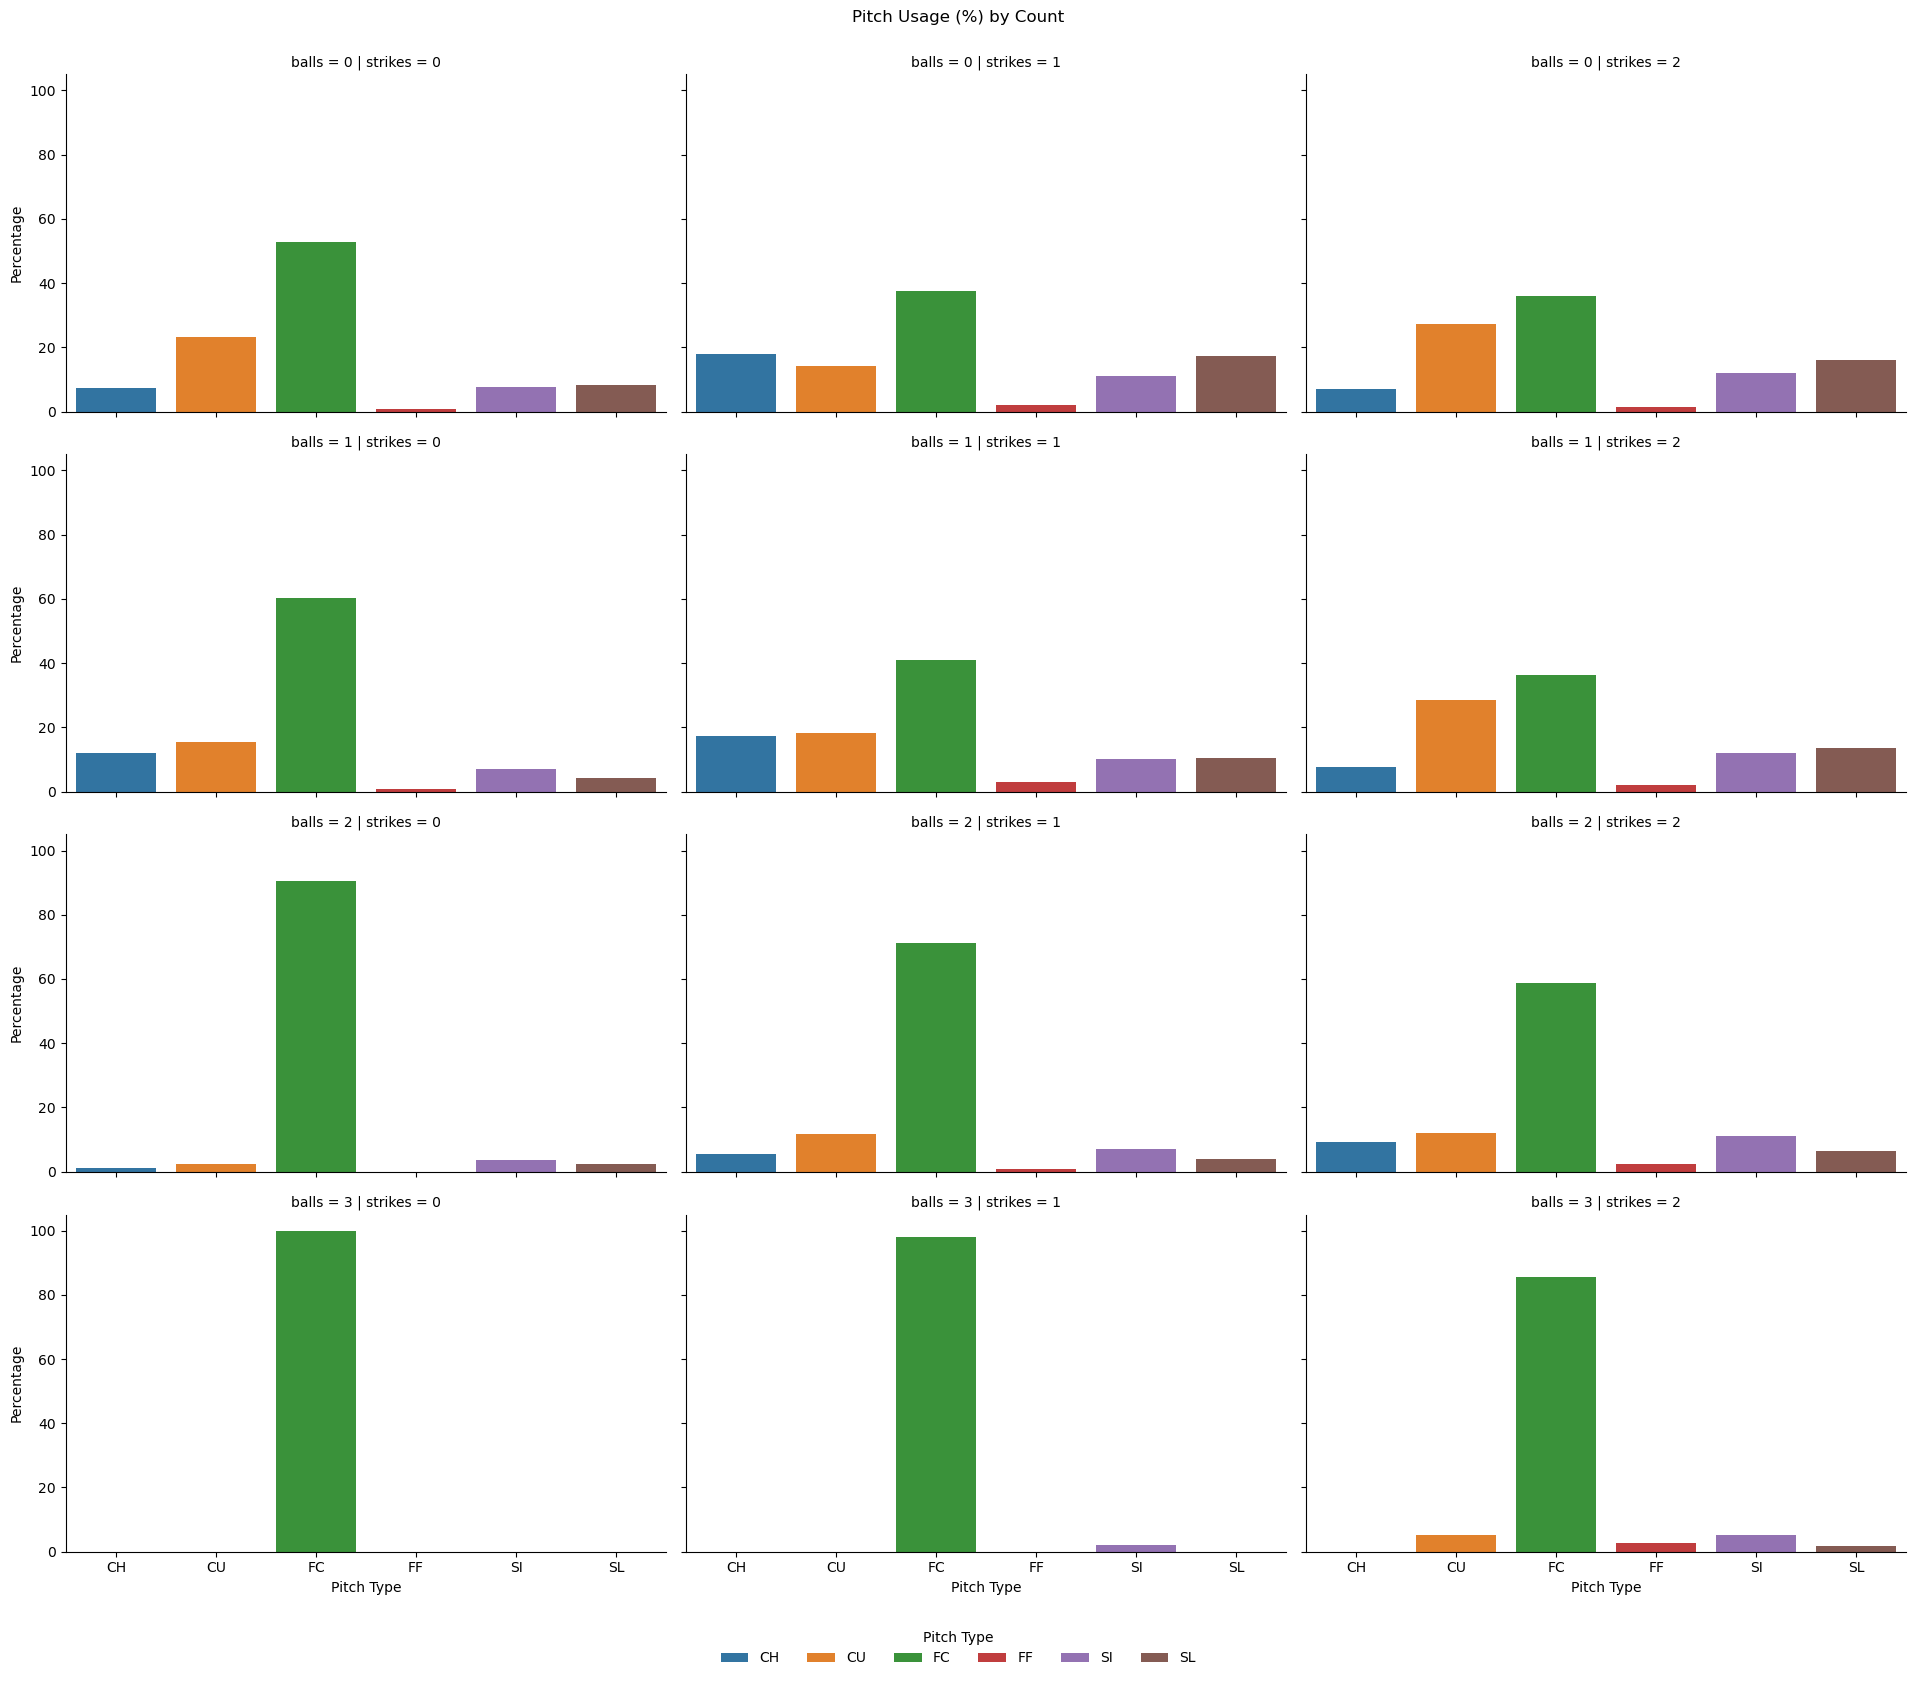

In [74]:
#The graphs below display the percent usage of pitch type based on the count
#There's no surprise that the cutter is utilized heavily when behind in the count. It's Corbin Burnes' best pitch and we see heavy usage
# in all counts. Never shying away from attacking hitters with your premium offering is characteristic of a Number 1 starter. Typically
# usage rates this high could result in hitters ambushing the cutter when ahead in the count but Burnes' cutter grades so high that it
# remains a challange for hitters even when they know it's coming. 
g = sns.FacetGrid(counts, col='strikes', row='balls', hue='pitch_type', height=4, aspect=1.2, legend_out = True)
g.map(sns.barplot, 'pitch_type', 'percentage', order=['CH', 'CU', 'FC', 'FF', 'SI', 'SL'])
g.set_axis_labels('Pitch Type', 'Percentage')
g.add_legend(title='Pitch Type', loc = 'upper center', bbox_to_anchor=(.5, -.005), ncol=6)

plt.suptitle('Pitch Usage (%) by Count', y=1)
plt.tight_layout()

In [76]:
#Importing package that contains season-level data from FanGraphs
from pybaseball import pitching_stats

In [82]:
#The first dataframe pulls season data for all pitchers who met the desired threshold of at least 15 ABs 
# during the 2021 season
#The second dataframe sorts by Cutter Stuff+ grade and selects top 10 graded pitchers
minqual_data = pitching_stats(2021, qual = 15)
bestFC = minqual_data.sort_values('Stf+ FC', ascending = False).head(10)

In [80]:
#Selects the grades of each of Corbin Burnes' pitches. This reflects what was shown in the graphs above.
#Knwoing your arsenal and attacking hitters with what you do best leads to success. 
burnesstuff = minqual_data.loc[minqual_data['Name'] == 'Corbin Burnes'][['Name', 'Stf+ FA', 'Stf+ SI', 'Stf+ FC', 
                                                                         'Stf+ SL', 'Stf+ CU', 'Stf+ CH']].copy()
burnesstuff

,Name,Stf+ FA,Stf+ SI,Stf+ FC,Stf+ SL,Stf+ CU,Stf+ CH
43,Corbin Burnes,104.0,94.0,163.0,140.0,148.0,81.0


In [41]:
#Creates a shadow effect on the plotted images. This will be utilized in the function below and will be
# explained in further detail there
from PIL import Image, ImageEnhance

def apply_alpha(image_path, alpha=0.3, zoom=0.15):
    """Apply alpha transparency to an image and return an OffsetImage."""
    # Open the image and convert to RGBA
    img = Image.open(image_path).convert("RGBA")
    
    # Adjust transparency (alpha) for the image
    alpha_channel = img.split()[3]
    alpha_channel = alpha_channel.point(lambda p: p * alpha)  # Apply transparency
    img.putalpha(alpha_channel)

    return OffsetImage(img, zoom=zoom)

In [88]:
#importing the necessary packages to be used in the function below
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from typing import Optional

In [37]:
#I want to be very clear that the following function is not entirely my own. I used the code from PyBaseball 
# GitHub page (link below). I have modified the code based on my own desired output. The edits I made are as follows:
#1. Added a second dataframe to the function's requirements to create the overlay that "highlights" the desired players on the plot
#2. Edited the path of the images to reflect where they are in my computer
#3. In the first for loop, I used the function above to adjust the transparency of the images before they were plotted. 
#4. To remove clutter, the annotations for player name in the first plot were removed
#5. To account for players who played on multiple teams during the season (trade, waivers, etc), I edited the except code
# to plot the MLB logo instead of an abbreviation
#6. The second for loop was edited to operate similarly to the first but does not apply the function to adjust the transparency
# of the logos. This plots them on top with the normal colors to make them appear highlighted.
#7. Adjusted the code for the axis spacing, axes, and league average so it corresponds with the background datsa (basedata)
#8.Adjusted the size of the team logos plotted to limit clutter and provide space for player name annotations
# Link:   https://github.com/jldbc/pybaseball/blob/master/pybaseball/plotting.py
def plot_highlight_players(data: pd.DataFrame, basedata: pd.DataFrame, x_axis: str, y_axis: str, title: Optional[str] = None) -> None:
    """Plots a scatter plot with each MLB team

    Args:
        data: (pandas.DataFrame)
            pandas.DataFrame of Fangraphs team data (retrieved through team_batting or team_pitching)
        x_axis: (str)
            Stat name to be plotted as the x_axis of the chart
        y_axis: (str)
            Stat name to be plotted as the y_axis of the chart
        title: (str), default = None
            Optional: Title of the plot
    """

    data = data[['Name', 'Team', x_axis, y_axis]]
    basedata = basedata[['Name', 'Team', x_axis, y_axis]]
    fig, ax = plt.subplots(figsize = (8,8))

# League data will be in the background and will have Name annotation removed for clarity
    for index, row in basedata.iterrows():

        # If there is a logo image for the corresponding team, plot the Team's logo image
        try:
            # Get path of team logo
            path = f"/Users/will/Documents/PyBaseball/logos/{row['Team']}.png"

            # Read in the image from the folder location
            img = apply_alpha(path, alpha=0.3, zoom=0.15)

            # Convert the image into a plottable object
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)

            # Plot the logo
            ax.add_artist(ab)

        # If there is no logo image for the corresponding team, just plot the MLB logo
        except FileNotFoundError:
            img = apply_alpha('/Users/will/Documents/PyBaseball/logos/MLB.png', alpha=0.3, zoom=0.1)
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)
            ax.add_artist(ab)

    
    for index, row in data.iterrows():

        # If there is a logo image for the corresponding team, plot the Team's logo image
        try:
            # Get path of team logo
            path = f"/Users/will/Documents/PyBaseball/logos/{row['Team']}.png"

            # Read in the image from the folder location
            img = OffsetImage(plt.imread(path, format="png"), zoom=.18)

            # Convert the image into a plottable object
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)

            # Plot the MLB logo
            ax.add_artist(ab)

            ###add name annotations for individual player
            ax.annotate(row['Name'], (float(row[x_axis]), float(row[y_axis])), textcoords="offset points", 
                        xytext=(9,-2), ha='left', fontsize = 8)

        # If there is no logo image for the corresponding team, just plot the Player's name with the MLB logo
        except FileNotFoundError:
            img = OffsetImage(plt.imread('/Users/will/Documents/PyBaseball/logos/MLB.png', format="png"), zoom=.1)
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)
            ax.add_artist(ab)
            ax.annotate(row['Name'], (float(row[x_axis]), float(row[y_axis])), textcoords="offset points", 
                        xytext=(9,-2), ha='left', fontsize = 8)

    # add some spacing to the x axis and y axis so the logos stay within the bounds of the chart
    x_axis_spacing = (basedata[x_axis].max() - basedata[x_axis].min()) * .1
    y_axis_spacing = (basedata[y_axis].max() - basedata[y_axis].min()) * .1

    # set the axis with the spacing from above
    plt.xlim([basedata[x_axis].min() - x_axis_spacing, basedata[x_axis].max() + x_axis_spacing])
    plt.ylim([basedata[y_axis].min() - y_axis_spacing, basedata[y_axis].max() + y_axis_spacing])

    # Plot league average for y axis variable
    plt.axhline(y= basedata[y_axis].mean(), color='k', linestyle='-')
    plt.text(basedata[x_axis].min() - x_axis_spacing * .9, basedata[y_axis].mean() + y_axis_spacing * .1, 'League Average', fontsize = 6)

    # Plot league average for x axis variable
    plt.axvline(x= basedata[x_axis].mean(), color='k', linestyle='-')
    plt.text(basedata[x_axis].mean() + x_axis_spacing * .05, basedata[y_axis].min() - y_axis_spacing * .8, 'League Average',
             rotation=90, fontsize = 6)

    # Add title and labels
    if not title:
        title = f'Player {x_axis}/{y_axis}'

    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    plt.show()

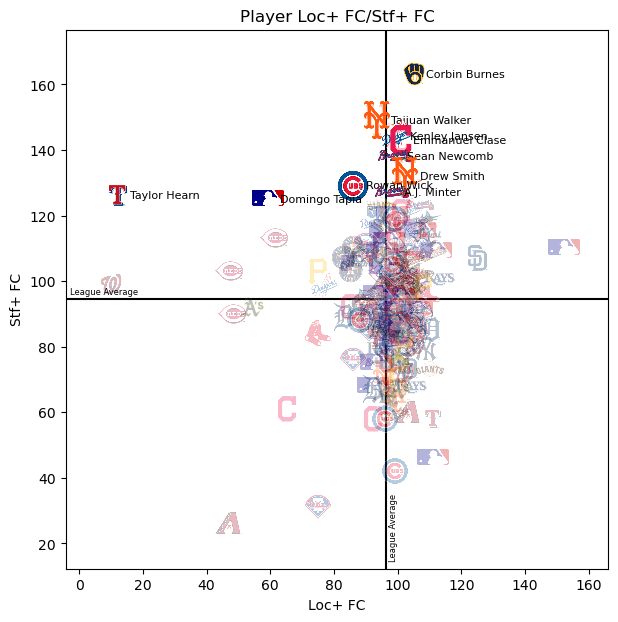

In [96]:
#Using the function from above, it gives us a strong indication to what makes Corbin Burnes' cutter so effective
#Among qualified pitchers, Corbin Burnes' cutter has the highest Stuff+ grade and, although not league-leading,
# his Location+ is ahead of the other pitchers in the top 10 of cutter Stuff+
plot_highlight_players(bestFC, minqual_data, 'Loc+ FC', 'Stf+ FC')

#### Home-Road Splits
+ PyBaseball has a package for retrieving pitcher splits data, but I was unable to have success loading the data into the Jupyter Notebook. I tried to manually collect the data from Baseball Reference using BeautifulSoup but my requests kept getting denied. 

### Home Analysis

In [100]:
#Using the pitch-level data from above, selecting only Brewers' home games
homedata = data.loc[data['home_team'] == 'MIL']

,player_name,home_team,events,description
1709,"Burnes, Corbin",MIL,NaN,called_strike
2492,"Burnes, Corbin",MIL,NaN,swinging_strike
1597,"Burnes, Corbin",MIL,NaN,foul
2624,"Burnes, Corbin",MIL,field_out,hit_into_play
1868,"Burnes, Corbin",MIL,NaN,ball
2324,"Burnes, Corbin",MIL,strikeout,swinging_strike
1206,"Burnes, Corbin",MIL,NaN,foul
2,"Burnes, Corbin",MIL,NaN,ball
956,"Burnes, Corbin",MIL,field_out,hit_into_play
670,"Burnes, Corbin",MIL,NaN,ball


In [102]:
#No surprise from a Cy Young winner, Corbin Burnes held it down at home, limiting opposing batters to 15 XBH
homedata.loc[homedata['events'].isin(['double', 'triple', 'home_run'])]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
189,FC,2021-09-25,95.3,-0.98,5.97,"Burnes, Corbin",624424,669203,double,hit_into_play,...,2,0,2,Standard,Standard,176.0,-0.024,0.202,NaN,NaN
270,FC,2021-09-18,93.1,-0.95,5.85,"Burnes, Corbin",664023,669203,home_run,hit_into_play,...,2,3,2,Standard,Standard,175.0,-0.284,1.877,NaN,NaN
478,FF,2021-09-05,97.9,-0.68,6.09,"Burnes, Corbin",664056,669203,double,hit_into_play,...,1,3,1,Strategic,Standard,196.0,-0.147,1.511,NaN,NaN
644,FC,2021-08-24,93.7,-0.88,5.81,"Burnes, Corbin",519058,669203,double,hit_into_play,...,1,3,1,Infield shift,Standard,175.0,-0.046,0.487,NaN,NaN
945,FC,2021-08-06,93.3,-0.93,5.77,"Burnes, Corbin",474832,669203,home_run,hit_into_play,...,1,1,1,Strategic,Standard,166.0,-0.170,1.027,NaN,NaN
1753,FC,2021-06-12,96.8,-1.03,5.87,"Burnes, Corbin",664789,669203,triple,hit_into_play,...,0,4,0,Strategic,Standard,199.0,-0.051,1.112,NaN,NaN
1758,FC,2021-06-12,95.3,-0.91,5.92,"Burnes, Corbin",570481,669203,triple,hit_into_play,...,0,3,0,Standard,Standard,206.0,-0.054,0.904,NaN,NaN
1941,FC,2021-05-31,96.4,-0.69,5.95,"Burnes, Corbin",600869,669203,double,hit_into_play,...,0,0,0,Strategic,Standard,186.0,-0.026,0.230,NaN,NaN
1967,FC,2021-05-31,96.3,-0.67,6.09,"Burnes, Corbin",622682,669203,double,hit_into_play,...,0,0,0,Standard,Standard,187.0,-0.089,0.968,NaN,NaN
2252,SI,2021-04-26,95.6,-0.87,5.90,"Burnes, Corbin",643265,669203,double,hit_into_play,...,0,3,0,Standard,Standard,199.0,-0.086,1.521,NaN,NaN


In [104]:
#Importing spraychat to display where the XBHs he gave up were located by hit type
from pybaseball import spraychart

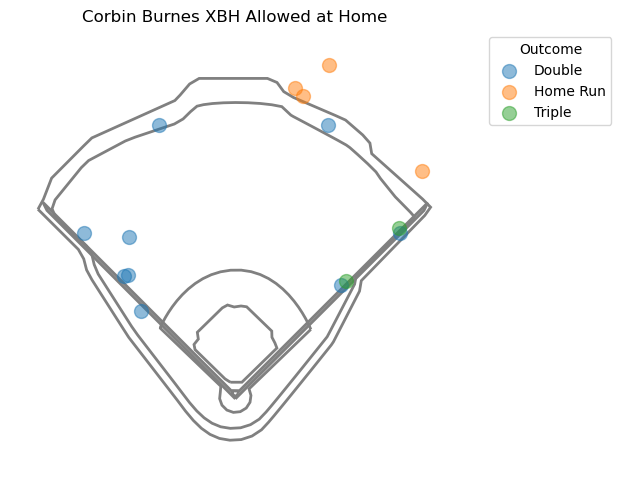

<Axes: title={'center': 'Corbin Burnes XBH Allowed at Home'}>

In [106]:
#using PyBaseball's spraychart visualization to show where his XBHs allowed fell
spraychart(homedata.loc[homedata['events'].isin(['double', 'triple', 'home_run'])], 'brewers', title='Corbin Burnes XBH Allowed at Home')

In [108]:
#More strikeouts than field outs confirms Burnes' dominance at home. We can also see the number of XBHs allowed by type 
homedata['events'].value_counts()

events
strikeout                    139
field_out                    133
single                        62
walk                          28
double                         9
grounded_into_double_play      6
force_out                      5
home_run                       4
hit_by_pitch                   3
sac_fly                        3
double_play                    2
triple                         2
sac_bunt                       1
field_error                    1
Name: count, dtype: int64

In [114]:
#Creating a little stat line which will be used below to compare home-away splits
import numpy as np

#DF to be used for the stat line. post_away_score and away_score to be used to calculate runs allowed
hometallies = homedata[['game_date', 'player_name', 'events','post_away_score', 'away_score']].copy()

In [116]:
#Creating dummies to be used to count totals of each XBH type
hometallies.loc[:, 'is_k'] = np.where(hometallies['events'] == 'strikeout', 1, 0)
hometallies.loc[:, 'is_walk'] = np.where(hometallies['events'] == 'walk', 1, 0)
hometallies.loc[:, 'is_single'] = np.where(hometallies['events'] == 'single', 1, 0)
hometallies.loc[:, 'is_double'] = np.where(hometallies['events'] == 'double', 1, 0)
hometallies.loc[:, 'is_triple'] = np.where(hometallies['events'] == 'triple', 1, 0)
hometallies.loc[:, 'is_homerun'] = np.where(hometallies['events'] == 'home_run', 1, 0)

hometallies.sample(5)

,game_date,player_name,events,post_away_score,away_score,is_k,is_walk,is_single,is_double,is_triple,is_homerun
1827,2021-06-06,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
2044,2021-05-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
230,2021-09-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
149,2021-09-25,"Burnes, Corbin",field_out,1,1,0,0,0,0,0,0
2657,2021-04-03,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
236,2021-09-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
202,2021-09-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
1523,2021-06-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
313,2021-09-18,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0
211,2021-09-25,"Burnes, Corbin",NaN,0,0,0,0,0,0,0,0


In [120]:
#Creating the runs_scored_on_pitch column and confirming it worked by displaying rows where at least one run was scored
hometallies.loc[:, 'runs_scored_on_pitch'] = hometallies['post_away_score'] - hometallies['away_score']
hometallies.loc[hometallies['runs_scored_on_pitch'] >=1][['player_name', 'events', 'post_away_score', 'away_score', 'runs_scored_on_pitch']]

,player_name,events,post_away_score,away_score,runs_scored_on_pitch
182,"Burnes, Corbin",single,1,0,1
270,"Burnes, Corbin",home_run,3,1,2
290,"Burnes, Corbin",force_out,1,0,1
478,"Burnes, Corbin",double,3,1,2
483,"Burnes, Corbin",sac_fly,1,0,1
637,"Burnes, Corbin",single,4,3,1
668,"Burnes, Corbin",sac_fly,3,2,1
671,"Burnes, Corbin",single,2,1,1
674,"Burnes, Corbin",single,1,0,1
945,"Burnes, Corbin",home_run,1,0,1


In [122]:
#Agg function to sum totals of desired stats
#With no unique game ID, game_date was used since we can comfortably assume no pitcher threw in multiple
# games on the same day - especially since Corbin Burnes is a starter
hometotals = hometallies.groupby('player_name').agg(
    G = ('game_date', 'nunique'),
    K = ('is_k', 'sum'), 
    BB = ('is_walk', 'sum'), 
    Singles = ('is_single', 'sum'), 
    Doubles = ('is_double', 'sum'), 
    Triples = ('is_triple', 'sum'), 
    HR = ('is_homerun', 'sum'),
    RA = ('runs_scored_on_pitch', 'sum'))
hometotals

,G,K,BB,Singles,Doubles,Triples,HR,RA
player_name,,,,,,,,
"Burnes, Corbin",17,139,28,62,9,2,4,30


### Away Analysis

In [126]:
#As this section follows the same process as the Home splits analysis above, there will be no comments until the end 
# of this section
awaydata = data.loc[data['home_team'] != 'MIL']
awaydata[['player_name', 'home_team', 'events', 'description']].sample(10)

,player_name,home_team,events,description
2535,"Burnes, Corbin",STL,NaN,ball
399,"Burnes, Corbin",CLE,NaN,foul
547,"Burnes, Corbin",SF,NaN,ball
2420,"Burnes, Corbin",SD,NaN,foul
557,"Burnes, Corbin",SF,NaN,ball
1235,"Burnes, Corbin",CIN,NaN,ball
1092,"Burnes, Corbin",ATL,NaN,ball
1424,"Burnes, Corbin",PIT,NaN,foul
424,"Burnes, Corbin",CLE,NaN,ball
363,"Burnes, Corbin",CLE,NaN,ball


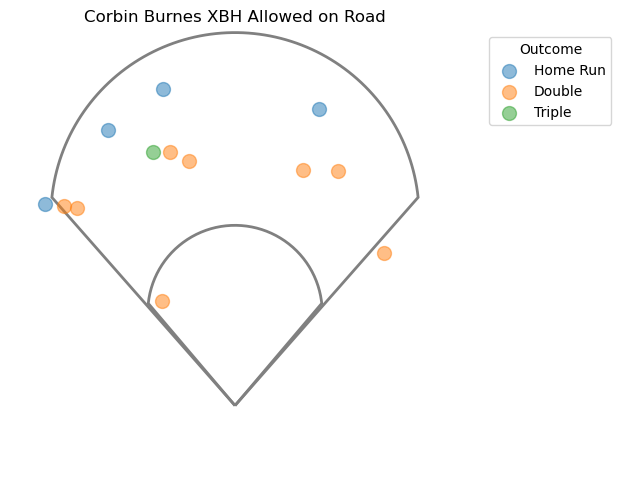

<Axes: title={'center': 'Corbin Burnes XBH Allowed on Road'}>

In [128]:
spraychart(awaydata.loc[awaydata['events'].isin(['double', 'triple', 'home_run'])], 'generic', title='Corbin Burnes XBH Allowed on Road')

In [130]:
awaydata.loc[awaydata['events'].isin(['double', 'triple', 'home_run'])]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
107,FC,2021-10-02,95.6,-0.69,5.90,"Burnes, Corbin",457759,669203,home_run,hit_into_play,...,3,3,1,Standard,Standard,192.0,0.276,2.443,NaN,NaN
542,CH,2021-08-30,90.0,-0.93,5.88,"Burnes, Corbin",474832,669203,double,hit_into_play,...,0,0,2,Infield shift,Standard,224.0,0.099,0.640,NaN,NaN
606,FC,2021-08-30,95.1,-0.85,5.99,"Burnes, Corbin",543105,669203,double,hit_into_play,...,0,0,2,Strategic,Standard,197.0,0.071,0.599,NaN,NaN
1043,FC,2021-07-30,95.0,-0.78,5.94,"Burnes, Corbin",592626,669203,double,hit_into_play,...,4,4,8,Infield shade,Standard,193.0,0.016,0.202,NaN,NaN
1108,CU,2021-07-30,81.9,-0.42,6.34,"Burnes, Corbin",663586,669203,home_run,hit_into_play,...,3,3,0,Standard,Standard,50.0,0.151,1.732,NaN,NaN
1326,FC,2021-07-07,93.1,-0.63,5.82,"Burnes, Corbin",624413,669203,double,hit_into_play,...,1,1,2,Standard,Standard,175.0,0.069,0.160,NaN,NaN
1404,FF,2021-07-07,97.6,-0.62,6.00,"Burnes, Corbin",607043,669203,double,hit_into_play,...,0,0,1,Infield shade,Standard,199.0,0.075,0.564,NaN,NaN
1459,FC,2021-07-01,94.5,-0.77,5.96,"Burnes, Corbin",592325,669203,home_run,hit_into_play,...,1,1,2,Standard,Standard,183.0,0.130,0.959,NaN,NaN
1599,SI,2021-06-18,96.0,-0.72,5.95,"Burnes, Corbin",602074,669203,double,hit_into_play,...,3,3,4,Standard,Standard,189.0,0.148,1.013,NaN,NaN
1606,CU,2021-06-18,79.9,-0.68,6.13,"Burnes, Corbin",663898,669203,double,hit_into_play,...,2,2,4,Standard,Standard,42.0,0.091,0.640,NaN,NaN


In [132]:
awaydata['events'].value_counts()

events
field_out                    113
strikeout                    110
single                        38
walk                          11
double                         8
force_out                      5
home_run                       4
hit_by_pitch                   3
grounded_into_double_play      2
field_error                    2
fielders_choice                1
caught_stealing_2b             1
double_play                    1
sac_fly                        1
triple                         1
Name: count, dtype: int64

In [134]:
awaytallies = awaydata[['game_date', 'player_name', 'events','post_home_score', 'home_score']].copy()

awaytallies.loc[:, 'is_k'] = np.where(awaytallies['events'] == 'strikeout', 1, 0)
awaytallies.loc[:, 'is_walk'] = np.where(awaytallies['events'] == 'walk', 1, 0)
awaytallies.loc[:, 'is_single'] = np.where(awaytallies['events'] == 'single', 1, 0)
awaytallies.loc[:, 'is_double'] = np.where(awaytallies['events'] == 'double', 1, 0)
awaytallies.loc[:, 'is_triple'] = np.where(awaytallies['events'] == 'triple', 1, 0)
awaytallies.loc[:, 'is_homerun'] = np.where(awaytallies['events'] == 'home_run', 1, 0)

In [136]:
awaytallies.loc[:, 'runs_scored_on_pitch'] = awaytallies['post_home_score'] - awaytallies['home_score']
awaytallies.loc[awaytallies['runs_scored_on_pitch'] >=1][['player_name', 'events', 'post_home_score', 'home_score', 'runs_scored_on_pitch']]

,player_name,events,post_home_score,home_score,runs_scored_on_pitch
107,"Burnes, Corbin",home_run,3,0,3
1022,"Burnes, Corbin",single,5,4,1
1095,"Burnes, Corbin",single,4,3,1
1108,"Burnes, Corbin",home_run,3,1,2
1111,"Burnes, Corbin",single,1,0,1
1399,"Burnes, Corbin",single,1,0,1
1459,"Burnes, Corbin",home_run,1,0,1
1599,"Burnes, Corbin",double,3,2,1
1615,"Burnes, Corbin",sac_fly,2,1,1
1654,"Burnes, Corbin",single,1,0,1


In [138]:
awaytotals = awaytallies.groupby('player_name').agg(
    G = ('game_date', 'nunique'),
    K = ('is_k', 'sum'), 
    BB = ('is_walk', 'sum'), 
    Singles = ('is_single', 'sum'), 
    Doubles = ('is_double', 'sum'), 
    Triples = ('is_triple', 'sum'), 
    HR = ('is_homerun', 'sum'),
    RA = ('runs_scored_on_pitch', 'sum'))
awaytotals

,G,K,BB,Singles,Doubles,Triples,HR,RA
player_name,,,,,,,,
"Burnes, Corbin",13,110,11,38,8,1,4,15


In [142]:
#The dataframe below shows a pretty consistent performance at home vs on the road. This is expected given the fact
# that we're looking at stats for a Cy Young winning season. You can't establish yourself as one of the top pitchers in the
# game without displaying mastery of your craft on a consistent basis. 
splitcomparison = pd.concat([hometotals, awaytotals]).reset_index()
splitcomparison['Split'] = ['Home', 'Away']
splitcomparison[['player_name', 'Split', 'G', 'K', 'BB', 'Singles', 'Doubles', 'Triples', 'HR', 'RA']]

,player_name,Split,G,K,BB,Singles,Doubles,Triples,HR,RA
0,"Burnes, Corbin",Home,17,139,28,62,9,2,4,30
1,"Burnes, Corbin",Away,13,110,11,38,8,1,4,15


### Comparison with 2021 Cy Young Candidates

In [9]:
#this package contains season-level pitching data from FanGraphs
from pybaseball import pitching_stats

In [7]:
#retrieving data from FanGraphs with the minimum qualification set to 1 AB
seasondata = pitching_stats(2021, qual = 1)
seasondata.sample(5)

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
216,17479,2021,Jack Flaherty,STL,25,9,2,0.9,3.22,17,...,NaN,NaN,NaN,NaN,94.0,100.0,100.0,NaN,NaN,NaN
74,11752,2021,Luke Jackson,ATL,29,2,2,0.6,1.98,71,...,NaN,NaN,NaN,NaN,135.0,96.0,105.0,NaN,NaN,NaN
884,13403,2021,Felix Pena,LAA,31,0,0,0.0,37.80,2,...,NaN,NaN,NaN,NaN,91.0,86.0,81.0,NaN,NaN,NaN
164,23779,2021,Justin Bruihl,LAD,24,0,1,0.2,2.89,21,...,98.0,NaN,NaN,NaN,89.0,98.0,95.0,NaN,NaN,NaN
521,20339,2021,Matt Peacock,ARI,27,5,7,-0.2,4.90,35,...,NaN,NaN,NaN,NaN,60.0,101.0,95.0,NaN,NaN,NaN


In [11]:
#Loading season-level data for the 2021 season for FanGraphs-qualified pitchers
leaguedata = pitching_stats(2021)

In [13]:
#There's an overwhelming number of columns to display, so I ended up going through the player page on the FanGraphs website to select
# which columns to be selected for analysis
seasondata.columns

Index(['IDfg', 'Season', 'Name', 'Team', 'Age', 'W', 'L', 'WAR', 'ERA', 'G',
       ...
       'Pit+ FC', 'Stf+ FS', 'Loc+ FS', 'Pit+ FS', 'Stuff+', 'Location+',
       'Pitching+', 'Stf+ FO', 'Loc+ FO', 'Pit+ FO'],
      dtype='object', length=393)

In [15]:
#Lance Lynn was absent from the dataset which led me to believe he did not meet the FanGraphs standard threshold of batters faced
# to be qualified. Therefore, I reloaded the data with a specified number of qualified ABs and checked the data to make sure the 
# information was present. 
seasondata[seasondata['Name'].str.contains('Lynn')]

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
137,2520,2021,Lance Lynn,CHW,34,11,6,4.3,2.69,28,...,101.0,NaN,NaN,NaN,98.0,103.0,101.0,NaN,NaN,NaN


In [17]:
#Creating a new dataframe to only contain season stats for the pitchers with the top three point totals after voting
cydata = seasondata.loc[seasondata['Name'].isin(['Corbin Burnes', 'Zack Wheeler', 'Max Scherzer', 
                                                         'Robbie Ray', 'Gerrit Cole', 'Lance Lynn'])]                                              
cydata

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
109,19361,2021,Corbin Burnes,MIL,26,11,5,7.5,2.43,28,...,115.0,NaN,NaN,NaN,143.0,104.0,111.0,NaN,NaN,NaN
148,10310,2021,Zack Wheeler,PHI,31,14,10,7.2,2.78,32,...,102.0,NaN,NaN,NaN,118.0,105.0,109.0,NaN,NaN,NaN
115,3137,2021,Max Scherzer,- - -,36,15,4,5.4,2.46,30,...,97.0,NaN,NaN,NaN,110.0,103.0,104.0,NaN,NaN,NaN
220,13125,2021,Gerrit Cole,NYY,30,16,8,5.2,3.23,30,...,NaN,NaN,NaN,NaN,137.0,104.0,113.0,NaN,NaN,NaN
137,2520,2021,Lance Lynn,CHW,34,11,6,4.3,2.69,28,...,101.0,NaN,NaN,NaN,98.0,103.0,101.0,NaN,NaN,NaN
158,11486,2021,Robbie Ray,TOR,29,13,7,3.9,2.84,32,...,NaN,NaN,NaN,NaN,99.0,102.0,103.0,NaN,NaN,NaN


In [19]:
#Trimming down the larger dataframe 
statscomp = cydata[['Name', 'Team', 'WAR', 'ERA', 'FIP', 'K%', 'BB%', 'WHIP', 'HR/9', 'BABIP']].copy()
statscomp

,Name,Team,WAR,ERA,FIP,K%,BB%,WHIP,HR/9,BABIP
109,Corbin Burnes,MIL,7.5,2.43,1.63,0.356,0.052,0.94,0.38,0.309
148,Zack Wheeler,PHI,7.2,2.78,2.59,0.291,0.054,1.01,0.68,0.288
115,Max Scherzer,- - -,5.4,2.46,2.97,0.341,0.052,0.86,1.15,0.247
220,Gerrit Cole,NYY,5.2,3.23,2.92,0.335,0.056,1.06,1.19,0.305
137,Lance Lynn,CHW,4.3,2.69,3.32,0.275,0.070,1.07,1.03,0.263
158,Robbie Ray,TOR,3.9,2.84,3.69,0.321,0.067,1.04,1.54,0.268


In [21]:
#For comparison, the average of some common statistics for our qualified pitchers 
leaguedata[['WAR', 'ERA', 'FIP', 'K%', 'BB%', 'WHIP', 'HR/9', 'BABIP']].mean()

WAR      3.633333
ERA      3.632564
FIP      3.669744
K%       0.247513
BB%      0.066128
WHIP     1.161538
HR/9     1.103077
BABIP    0.285846
dtype: float64

In [23]:
#Turning the output from above into a dataframe
qualifiedaverage = {
    'Name': ['Qualified Average'],
    'Team': ['MLB'],
    'WAR': [3.63],
    'ERA': [3.63], 
    'FIP': [3.67],
    'K%' : [.248],
    'BB%': [.066],
    'WHIP': [1.16],
    'HR/9': [1.10], 
    'BABIP': [.285]
}
qualifiedaverage = pd.DataFrame(qualifiedaverage)
qualifiedaverage

,Name,Team,WAR,ERA,FIP,K%,BB%,WHIP,HR/9,BABIP
0,Qualified Average,MLB,3.63,3.63,3.67,0.248,0.066,1.16,1.1,0.285


In [25]:
#Using concat to provide a glimpse of pitcher performance
cy_vs_league = pd.concat([statscomp, qualifiedaverage])
cy_vs_league

,Name,Team,WAR,ERA,FIP,K%,BB%,WHIP,HR/9,BABIP
109,Corbin Burnes,MIL,7.50,2.43,1.63,0.356,0.052,0.94,0.38,0.309
148,Zack Wheeler,PHI,7.20,2.78,2.59,0.291,0.054,1.01,0.68,0.288
115,Max Scherzer,- - -,5.40,2.46,2.97,0.341,0.052,0.86,1.15,0.247
220,Gerrit Cole,NYY,5.20,3.23,2.92,0.335,0.056,1.06,1.19,0.305
137,Lance Lynn,CHW,4.30,2.69,3.32,0.275,0.070,1.07,1.03,0.263
158,Robbie Ray,TOR,3.90,2.84,3.69,0.321,0.067,1.04,1.54,0.268
0,Qualified Average,MLB,3.63,3.63,3.67,0.248,0.066,1.16,1.10,0.285


In [29]:
#importing the necessary packages to be used in the function below
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from typing import Optional

In [31]:
#I want to be very clear that the following function is not entirely my own. I used the code from PyBaseball 
# GitHub page (link below). I have modified the code based on my own desired output. The edits I made are as follows:
#1. Edited the path of the images to reflect where they are in my computer
#2. To account for players who played on multiple teams during the season (trade, waivers, etc), I edited the except code
# to plot the MLB logo instead of an abbreviation
#3. Renamed the 'League Avevrage' axis to 'Sample Average' to more accurately reflect its value
#4. Adjusted the size of the team logos plotted to limit clutter and provide space for player name annotations
# Link:   https://github.com/jldbc/pybaseball/blob/master/pybaseball/plotting.py

def plot_season_stats(data: pd.DataFrame, x_axis: str, y_axis: str, title: Optional[str] = None) -> None:
    """Plots a scatter plot with each MLB team

    Args:
        data: (pandas.DataFrame)
            pandas.DataFrame of Fangraphs team data (retrieved through team_batting or team_pitching)
        x_axis: (str)
            Stat name to be plotted as the x_axis of the chart
        y_axis: (str)
            Stat name to be plotted as the y_axis of the chart
        title: (str), default = None
            Optional: Title of the plot
    """

    data = data[['Name', 'Team', x_axis, y_axis]]

    fig, ax = plt.subplots(figsize = (8,8))

    for index, row in data.iterrows():

        # If there is a logo image for the corresponding team, plot the Team's logo image
        try:
            # Get path of team logo
            path = f"/Users/will/Documents/PyBaseball/logos/{row['Team']}.png"

            # Read in the image from the folder location
            img = OffsetImage(plt.imread(path, format="png"), zoom=.15)

            # Convert the image into a plottable object
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)

            # Plot the MLB logo
            ax.add_artist(ab)

            ###add name annotations for individual player
            ax.annotate(row['Name'], (float(row[x_axis]), float(row[y_axis])), textcoords="offset points", 
                        xytext=(9,-2), ha='left', fontsize = 8)

        # If there is no logo image for the corresponding team, just plot the Player's name with the MLB logo
        except FileNotFoundError:
            img = OffsetImage(plt.imread('/Users/will/Documents/PyBaseball/logos/MLB.png', format="png"), zoom=.1)
            ab = AnnotationBbox(img, (float(row[x_axis]), float(row[y_axis])), frameon=False)
            ax.add_artist(ab)
            ax.annotate(row['Name'], (float(row[x_axis]), float(row[y_axis])), textcoords="offset points", 
                        xytext=(9,-2), ha='left', fontsize = 8)

    # add some spacing to the x axis and y axis so the logos stay within the bounds of the chart
    x_axis_spacing = (data[x_axis].max() - data[x_axis].min()) * .1
    y_axis_spacing = (data[y_axis].max() - data[y_axis].min()) * .1

    # set the axis with the spacing from above
    plt.xlim([data[x_axis].min() - x_axis_spacing, data[x_axis].max() + x_axis_spacing])
    plt.ylim([data[y_axis].min() - y_axis_spacing, data[y_axis].max() + y_axis_spacing])

    # Plot league average for y axis variable
    plt.axhline(y=data[y_axis].mean(), color='k', linestyle='-')
    plt.text(data[x_axis].min() - x_axis_spacing * .9, data[y_axis].mean() + y_axis_spacing * .1, 'Sample Average', fontsize = 6)

    # Plot league average for x axis variable
    plt.axvline(x=data[x_axis].mean(), color='k', linestyle='-')
    plt.text(data[x_axis].mean() + x_axis_spacing * .05, data[y_axis].min() - y_axis_spacing * .8, 'Sample Average',
             rotation=90, fontsize = 6)

    # Add title and labels
    if not title:
        title = f'Player {x_axis}/{y_axis}'

    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)

    plt.show()

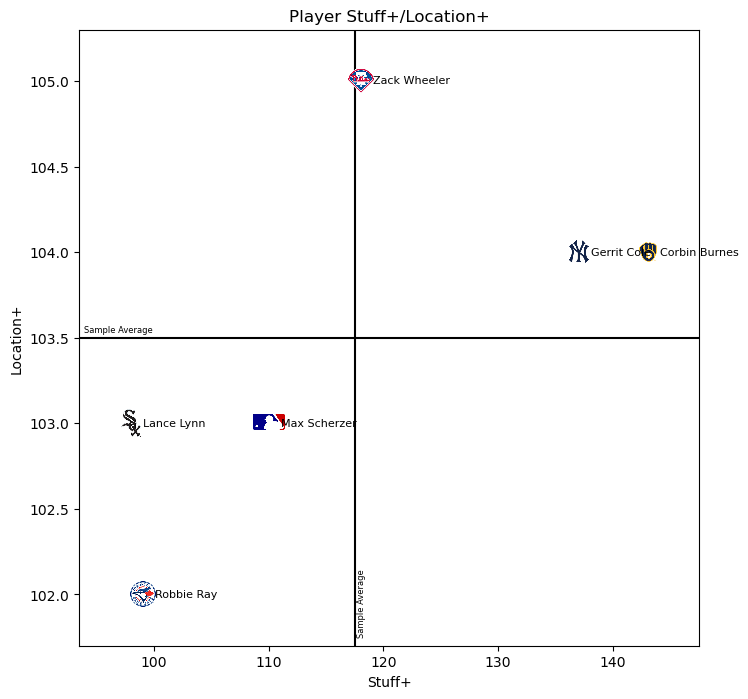

In [33]:
#In the small sample of the leading Cy Young candidates based on points, Corbin Burnes displays the ability to not only
# have one of the best arsenals in the game but no issues harnessing the nasty pitches as well. 
plot_season_stats(cydata, 'Stuff+', 'Location+')

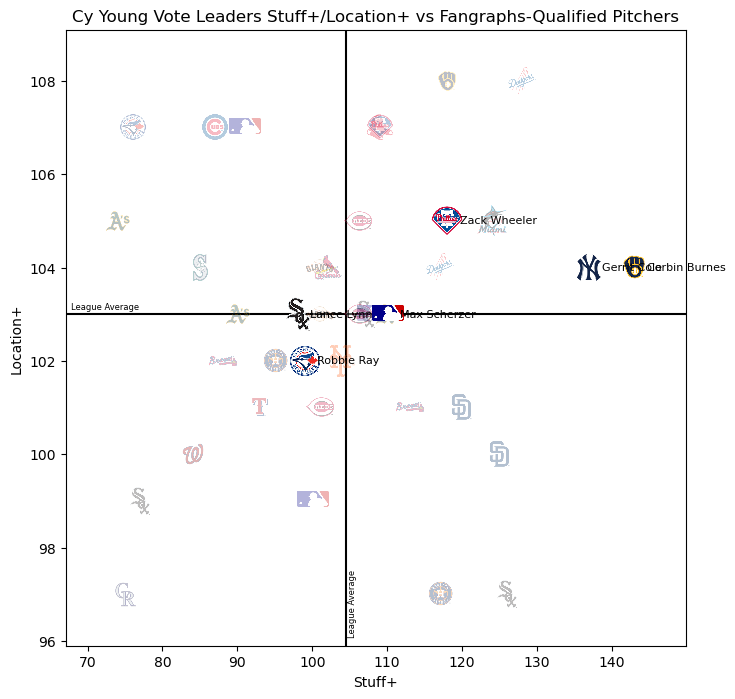

In [43]:
#Using the plot_highlight_players function from above, we can see how the top three finishers for Cy Young voting in each league
# compare to other FanGraphs-qualified pitchers and the league average
plot_highlight_players(cydata, leaguedata, 'Stuff+', 'Location+', title = 'Cy Young Vote Leaders Stuff+/Location+ vs Fangraphs-Qualified Pitchers')

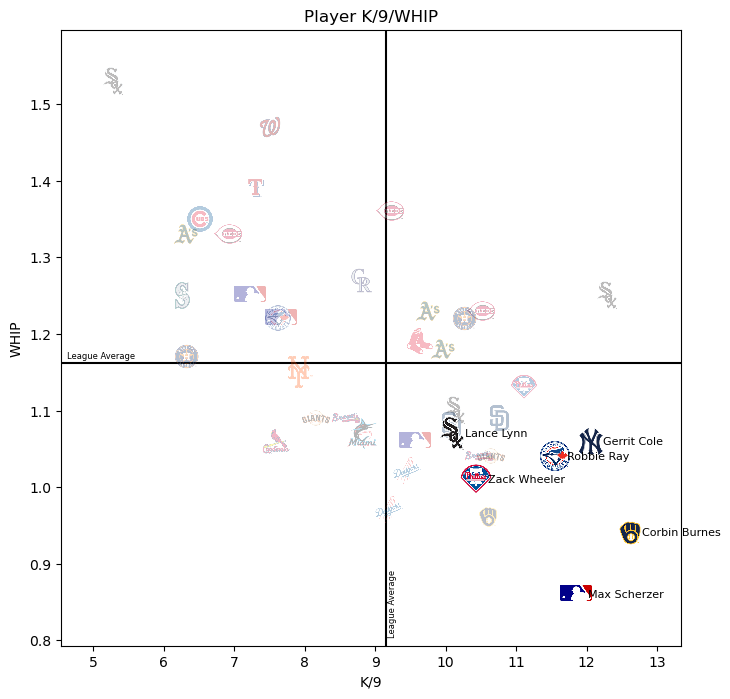

In [45]:
#The graph below dispalys how well the pitchers limited traffic (WHIP), and their ability to put hitters away. 
#Pitchers with the ability to put hitters away via strikeout can play a large role in limiting runs allowed - especially
# with runners on base. Collecting outs without the ball being put in play prevents runners from being moved over whether by hit, 
# error, or fielder's choice. The most dominant pitchers in baseball in 2021 all had well above average K/9 and WHIP.
plot_highlight_players(cydata, leaguedata, 'K/9', 'WHIP')

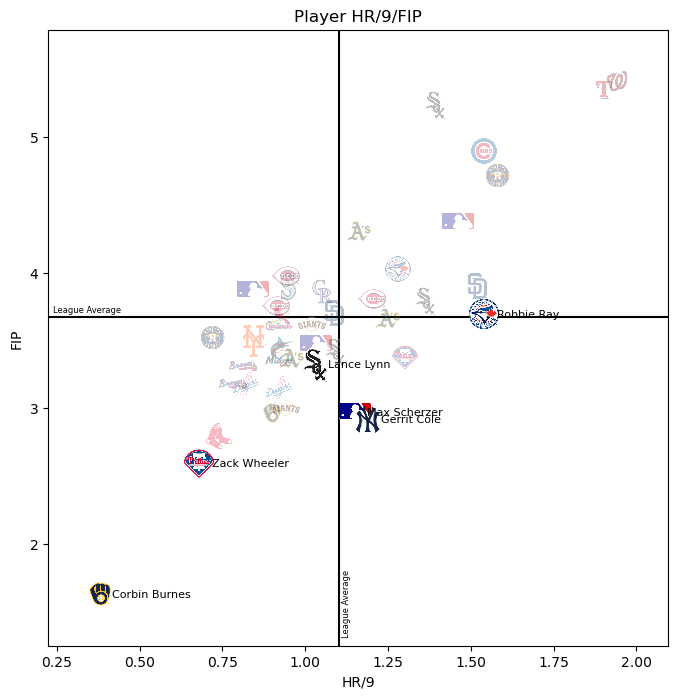

In [47]:
#Next, let's look at where Corbin Burnes ranks with FIP and HR/9. Homeruns allowed is a component of FIP calculation so there will
# be strong positive correlation between the two. 
#Corbin Burnes' 2021 season was stingy to say the least when it came to HR/9 with .38. This left opposing teams trying to manufacture
# runs on a pitcher with one of the highest K/9 and lowest WHIPs in the league. 
plot_highlight_players(cydata, leaguedata, 'HR/9', 'FIP')